Goal: simulate consumer resource model and find parameter values


\begin{align*}
    \dot{x} &=  \bigg[\gamma_A r_A \frac{A}{K_A + A} + \gamma_I r_I \frac{I}{K_I + I} \bigg] \frac{\tilde{C}}{K_C + \tilde{C}}x - \mu x\\
    \dot{A} &= -r_A \frac{A}{K_A + A} x\\
    \dot{I} &= \bigg[r_A \frac{A}{K_A + A} - r_I \frac{I}{K_I + I} \bigg]x\\
    \dot{\tilde{C}} &= - \frac{\tilde{C}}{K_C + \tilde{C}} x
\end{align*}

Here, $\tilde{C} = C/r_c$ is the normalized amount of limiting nutrient. Here, we then wish to fit rate and uptake parameters ($r$ and $\gamma$) as well as the initial biomass $x(0)$. We will use a sensitivity analysis to select $C(0)$ as well as each affinity, $K$.

In [8]:
import numpy as np

def RHS(x, A, I, C, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu):
    dx = (gamma_A*r_A*A/(K_A + A) + gamma_I*r_I*I/(K_I + I))*x*C/(K_C + C) - mu*x
    dA = -r_A*x*A/(K_A + A)
    dI = (r_A*A/(K_A + A) - r_I*I/(K_I + I))*x
    dC = - x*C/(K_C + C)
    return dx, dA, dI, dC

#use RK4
def timestep(x_n, A_n, I_n, C_n, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt):
    k_1 = RHS(x_n, A_n, I_n, C_n, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu)
    k_2 = RHS(x_n + dt*k_1[0]/2, A_n + dt*k_1[1]/2, I_n + dt*k_1[2]/2, C_n + dt*k_1[3]/2, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu)
    k_3 = RHS(x_n + dt*k_2[0]/2, A_n + dt*k_2[1]/2, I_n + dt*k_2[2]/2, C_n + dt*k_2[3]/2, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu)
    k_4 = RHS(x_n + dt*k_3[0], A_n + dt*k_3[1], I_n + dt*k_3[2], C_n + dt*k_3[3], gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu)
    x_new = x_n + (dt/6)*(k_1[0] + 2*k_2[0] + 2*k_3[0] + k_4[0])
    A_new = A_n + (dt/6)*(k_1[1] + 2*k_2[1] + 2*k_3[1] + k_4[1])
    I_new = I_n + (dt/6)*(k_1[2] + 2*k_2[2] + 2*k_3[2] + k_4[2])
    C_new = C_n + (dt/6)*(k_1[3] + 2*k_2[3] + 2*k_3[3] + k_4[3])
    return x_new, A_new, I_new, C_new
    
def simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt, T):
    N = int(T/dt)
    x = np.zeros(N); x[0] = x_0
    A = np.zeros(N); A[0] = A_0
    I = np.zeros(N); I[0] = I_0
    C = np.zeros(N); C[0] = C_0
    for i in range(N-1):
        new = timestep(x[i], A[i], I[i], C[i], gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt)
        x[i + 1] = new[0]
        A[i + 1] = new[1]
        I[i + 1] = new[2]
        C[i + 1] = new[3]
        
    return x, A, I, C
    
    

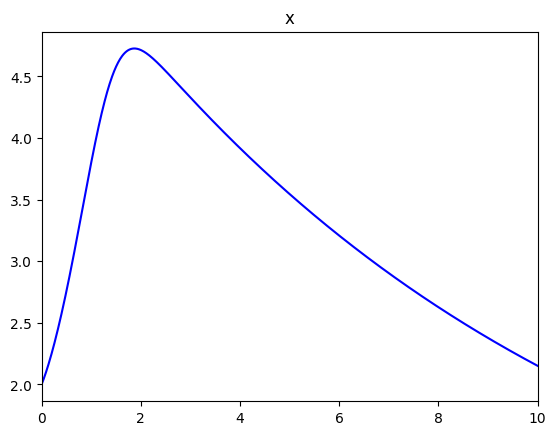

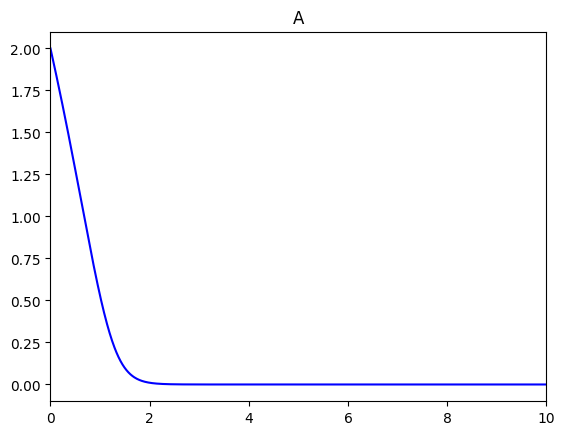

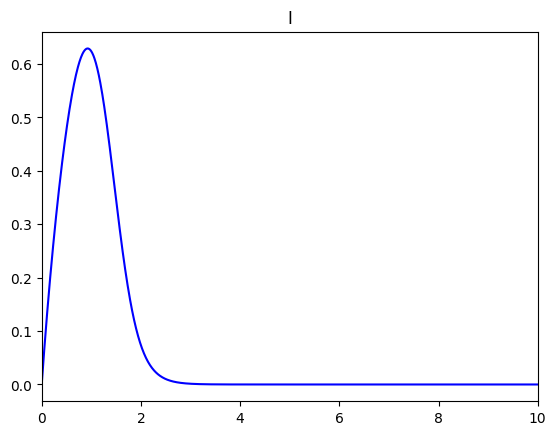

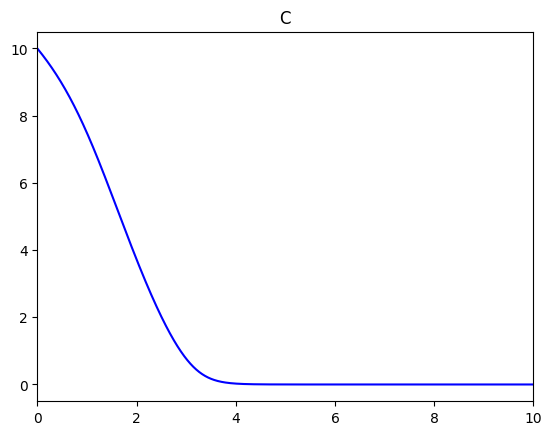

In [5]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.01
T = 10
x_0 = 2
A_0 = 2
I_0 = 0
C_0 = 10
gamma_A = 1
gamma_I = 1
r_A = 1
r_I = 1
K_A = K_I = K_C = 1
mu = 0.1

x, A, I, C = simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt, T)
t = np.linspace(0, T, int(T/dt))

plt.plot(t, x, color = 'blue')
plt.xlim(0,T)
plt.title('x')
plt.show()
plt.plot(t, A, color = 'blue')
plt.xlim(0,T)
plt.title('A')
plt.show()
plt.plot(t, I, color = 'blue')
plt.xlim(0,T)
plt.title('I')
plt.show()
plt.plot(t, C, color = 'blue')
plt.xlim(0,T)
plt.title('C')
plt.show()

Run a curvefit.

Optimized parameters:
gamma_A = 0.9657
gamma_I = 0.0001
r_A = 0.4960
r_I = 16.6276


(0.0, 9.0)

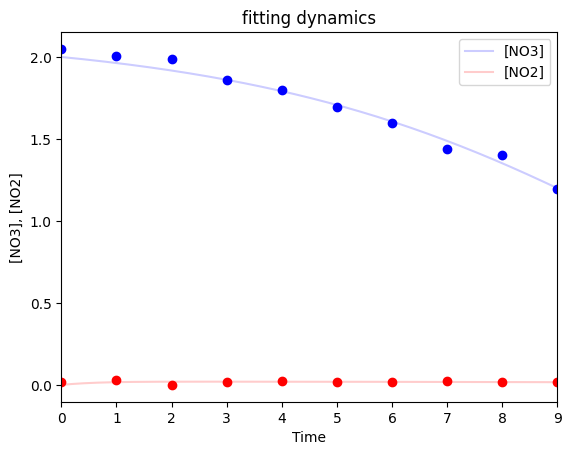

In [9]:
from scipy.optimize import curve_fit
from mgsa.io import get_function, samples_from_soils

native = 5 #which native soil (0 through 9)
pert = 3 #which perturbed soil (0 through 10)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
sample = samples_from_soils(soils[native])[pert]


t_data = np.linspace(0,19,20)
function = get_function(sample)

A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
    
A_data = A_data/3
I_data = I_data/3

y_data = np.concatenate([A_data, I_data])

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 3
K_A = K_I = K_C = 1
mu = 0.01 
dt = 0.05
T = 9
N = int(T/dt)

def model(t, gamma_A, gamma_I, r_A, r_I):
    
    indices = np.linspace(0,int(9/dt-1),10).astype(int)
    
    _, A, I, _ = simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt, T)
    A_out = A[indices]
    I_out = I[indices]
    
    return np.concatenate([A_out, I_out])

initial_guess = [1.0, 1.0, 0.1, 0.1] 


bounds = ([0.0001, 0.0001, 0.0001, 0.0001], [100, 100, 100, 100])


popt, pcov = curve_fit(model, t_data, y_data, 
                        p0=initial_guess, 
                        bounds=bounds,
                        maxfev=100000)  

print("Optimized parameters:")
print(f"gamma_A = {popt[0]:.4f}")
print(f"gamma_I = {popt[1]:.4f}")
print(f"r_A = {popt[2]:.4f}")
print(f"r_I = {popt[3]:.4f}")

x, A, I, C = simulate(x_0, A_0, I_0, C_0, popt[0], popt[1], popt[2], popt[3], K_A, K_I, K_C, mu, dt, T)


t = np.linspace(0,9,N)
t_scatter = np.linspace(0,9,10)


plt.plot(t, A, color = 'Blue', alpha = 0.2, label = '[NO3]')
plt.plot(t, I, color = 'Red', alpha = 0.2, label = '[NO2]')
plt.title('fitting dynamics')
plt.scatter(t_scatter, A_data, color = 'Blue')
plt.scatter(t_scatter, I_data, color = 'Red')
plt.xlabel('Time')
plt.legend()
plt.ylabel('[NO3], [NO2]')
plt.xlim(0,9)

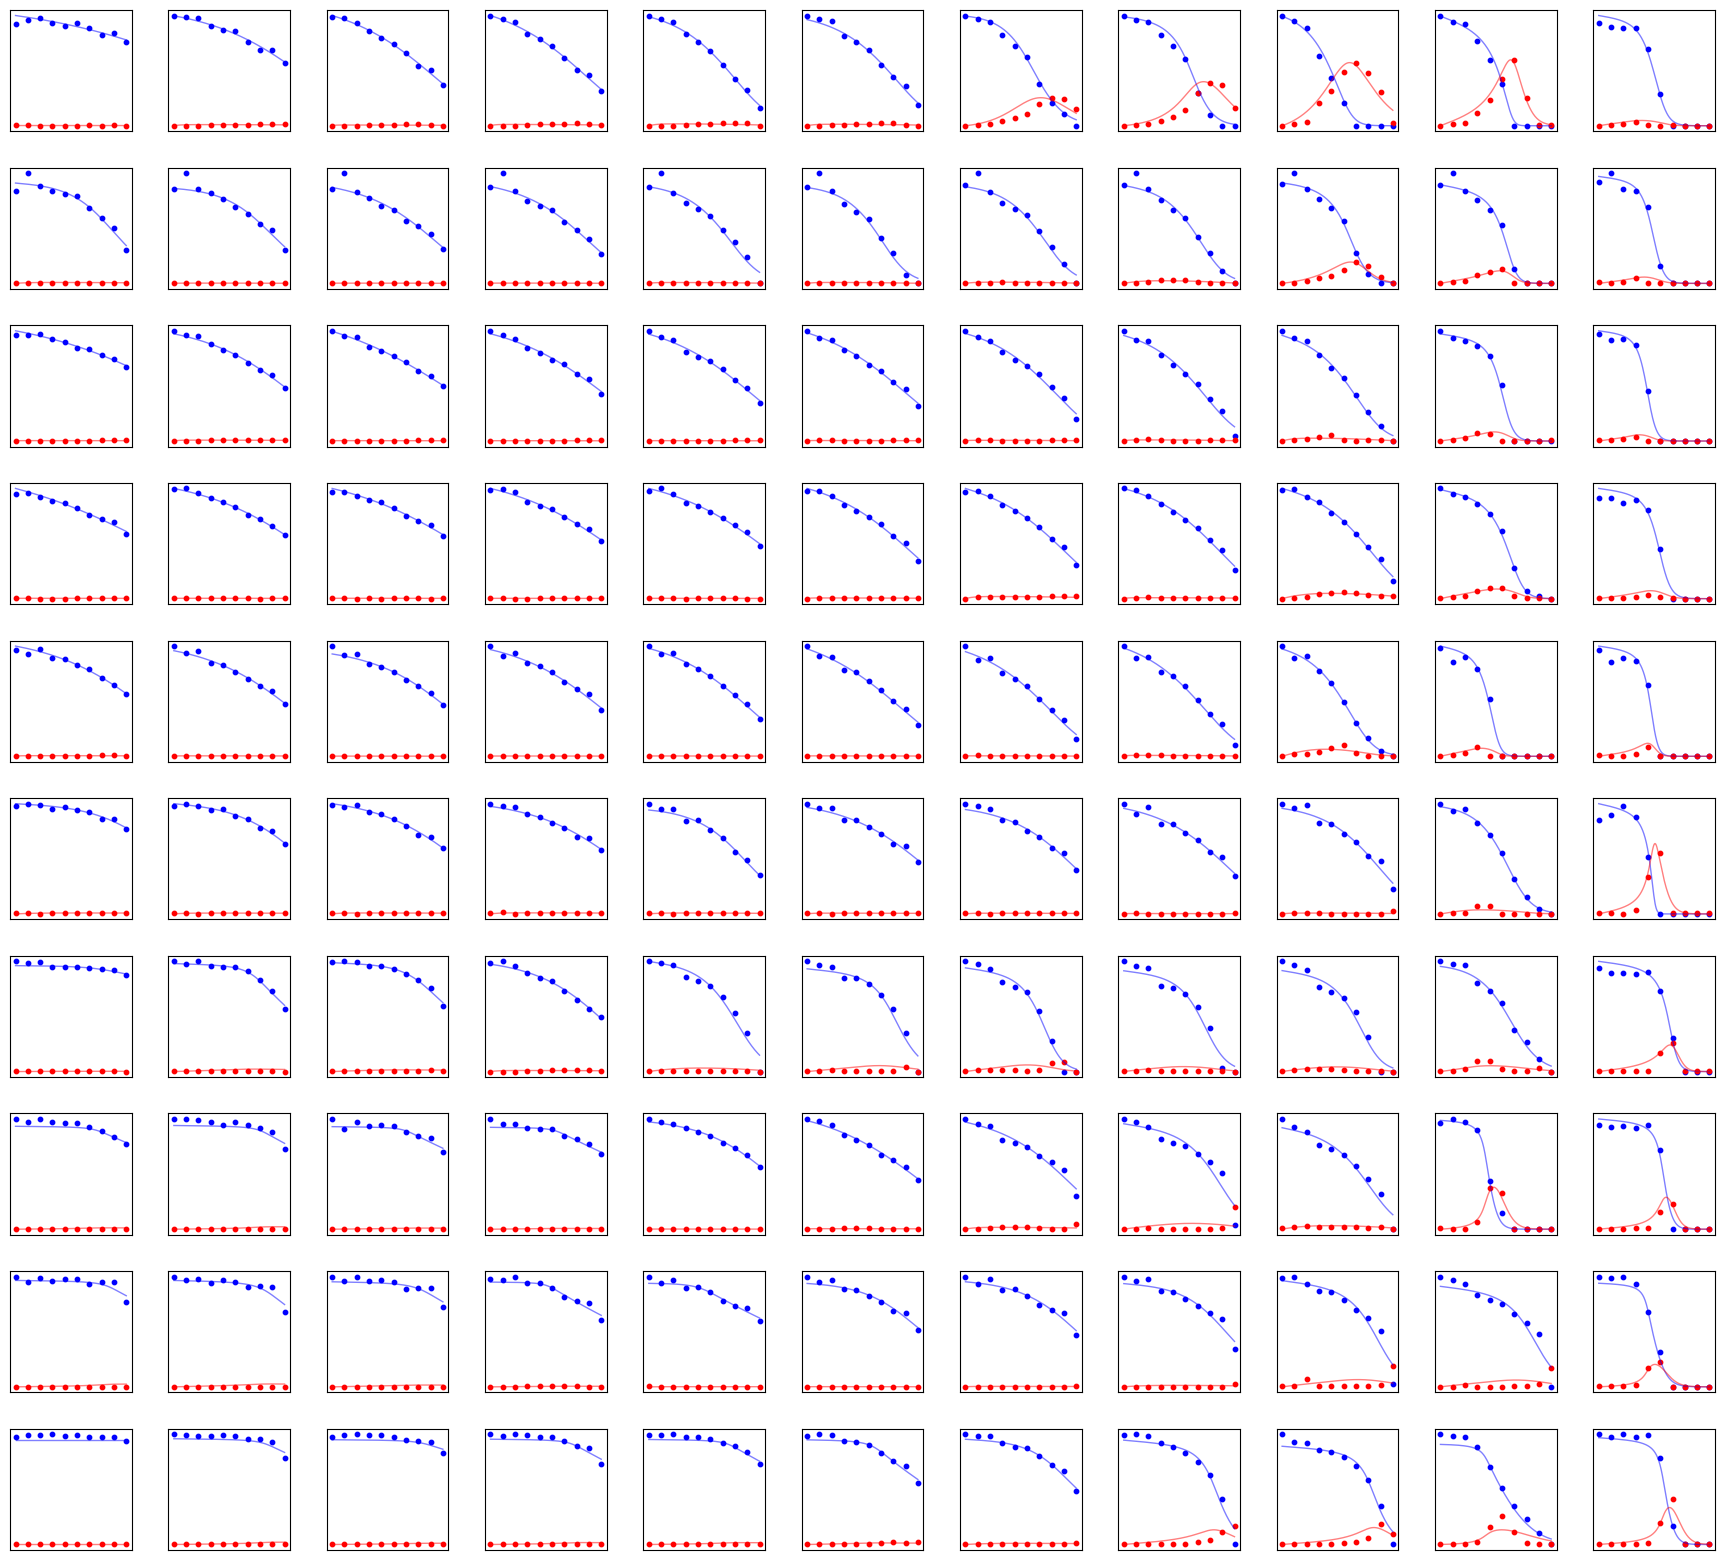

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mgsa.io import get_function, samples_from_soils

# Initialize figure
fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Constants and initial parameters
t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 3
K_A = K_I = K_C = 1
mu = 0.01 
dt = 0.05
T = 9
N = int(T/dt)

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[native])[pert]
        function = get_function(sample)
        
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model(t, gamma_A, gamma_I, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, 
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0, 0.1, 0.1]
        bounds = ([0.0001, 0.0001, 0.0001, 0.0001], [100, 100, 100, 100])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        x, A, I, C = simulate(x_0, A_0, I_0, C_0, popt[0], popt[1], 
                              popt[2], popt[3], K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

# Repeat but for CHL +

In [9]:
import numpy as np

def RHS_drug(x, A, I, C, r_A, r_I, K_A, K_I, K_C, mu):
    dx = - mu*x
    dA = -r_A*x*A/(K_A + A)
    dI = (r_A*A/(K_A + A) - r_I*I/(K_I + I))*x
    dC = - x*C/(K_C + C)
    return dx, dA, dI, dC

#use RK4
def timestep_drug(x_n, A_n, I_n, C_n, r_A, r_I, K_A, K_I, K_C, mu, dt):
    k_1 = RHS_drug(x_n, A_n, I_n, C_n, r_A, r_I, K_A, K_I, K_C, mu)
    k_2 = RHS_drug(x_n + dt*k_1[0]/2, A_n + dt*k_1[1]/2, I_n + dt*k_1[2]/2, C_n + dt*k_1[3]/2, r_A, r_I, K_A, K_I, K_C, mu)
    k_3 = RHS_drug(x_n + dt*k_2[0]/2, A_n + dt*k_2[1]/2, I_n + dt*k_2[2]/2, C_n + dt*k_2[3]/2, r_A, r_I, K_A, K_I, K_C, mu)
    k_4 = RHS_drug(x_n + dt*k_3[0], A_n + dt*k_3[1], I_n + dt*k_3[2], C_n + dt*k_3[3], r_A, r_I, K_A, K_I, K_C, mu)
    x_new = x_n + (dt/6)*(k_1[0] + 2*k_2[0] + 2*k_3[0] + k_4[0])
    A_new = A_n + (dt/6)*(k_1[1] + 2*k_2[1] + 2*k_3[1] + k_4[1])
    I_new = I_n + (dt/6)*(k_1[2] + 2*k_2[2] + 2*k_3[2] + k_4[2])
    C_new = C_n + (dt/6)*(k_1[3] + 2*k_2[3] + 2*k_3[3] + k_4[3])
    return x_new, A_new, I_new, C_new
    
def simulate_drug(x_0, A_0, I_0, C_0, r_A, r_I, K_A, K_I, K_C, mu, dt, T):
    N = int(T/dt)
    x = np.zeros(N); x[0] = x_0
    A = np.zeros(N); A[0] = A_0
    I = np.zeros(N); I[0] = I_0
    C = np.zeros(N); C[0] = C_0
    for i in range(N-1):
        new = timestep_drug(x[i], A[i], I[i], C[i], r_A, r_I, K_A, K_I, K_C, mu, dt)
        x[i + 1] = new[0]
        A[i + 1] = new[1]
        I[i + 1] = new[2]
        C[i + 1] = new[3]
        
    return x, A, I, C
    
    

[1.83714106 1.87114004 1.8228906  1.7613589  1.73076829 1.79871642
 1.6782105  1.56090158 1.62401016 1.53055037]
[1.99156326 1.99495553 1.89967067 1.83997452 1.75756881 1.7505595
 1.59745287 1.74059149 1.53071539 1.54791169]
[1.97191188 1.91067924 1.88098399 1.74650435 1.68283596 1.68858226
 1.54930965 1.3994354  1.39700217 1.23866509]
[1.94977755 1.89405445 1.88284855 1.75395487 1.68640235 1.6614748
 1.52591614 1.35674108 1.40258341 1.20411457]
[1.99907123 1.91813564 1.93002436 1.79477379 1.73501741 1.73142036
 1.59428294 1.4121424  1.41641656 1.25435822]
[1.98776165 1.9641461  1.92774987 1.81957455 1.75634306 1.73398033
 1.55151623 1.40172921 1.41997774 1.23918128]
[2.00164948 1.89231365 1.90374676 1.75650021 1.71231283 1.68607959
 1.56218704 1.39114778 1.39118401 1.24883984]
[1.96969368 1.90570936 1.86499038 1.76354941 1.67357004 1.69551894
 1.59463498 1.39676716 1.40995548 1.27963514]
[1.94966444 1.86341414 1.90717989 1.73886813 1.67666188 1.64755294
 1.56481758 1.40435284 1.399809

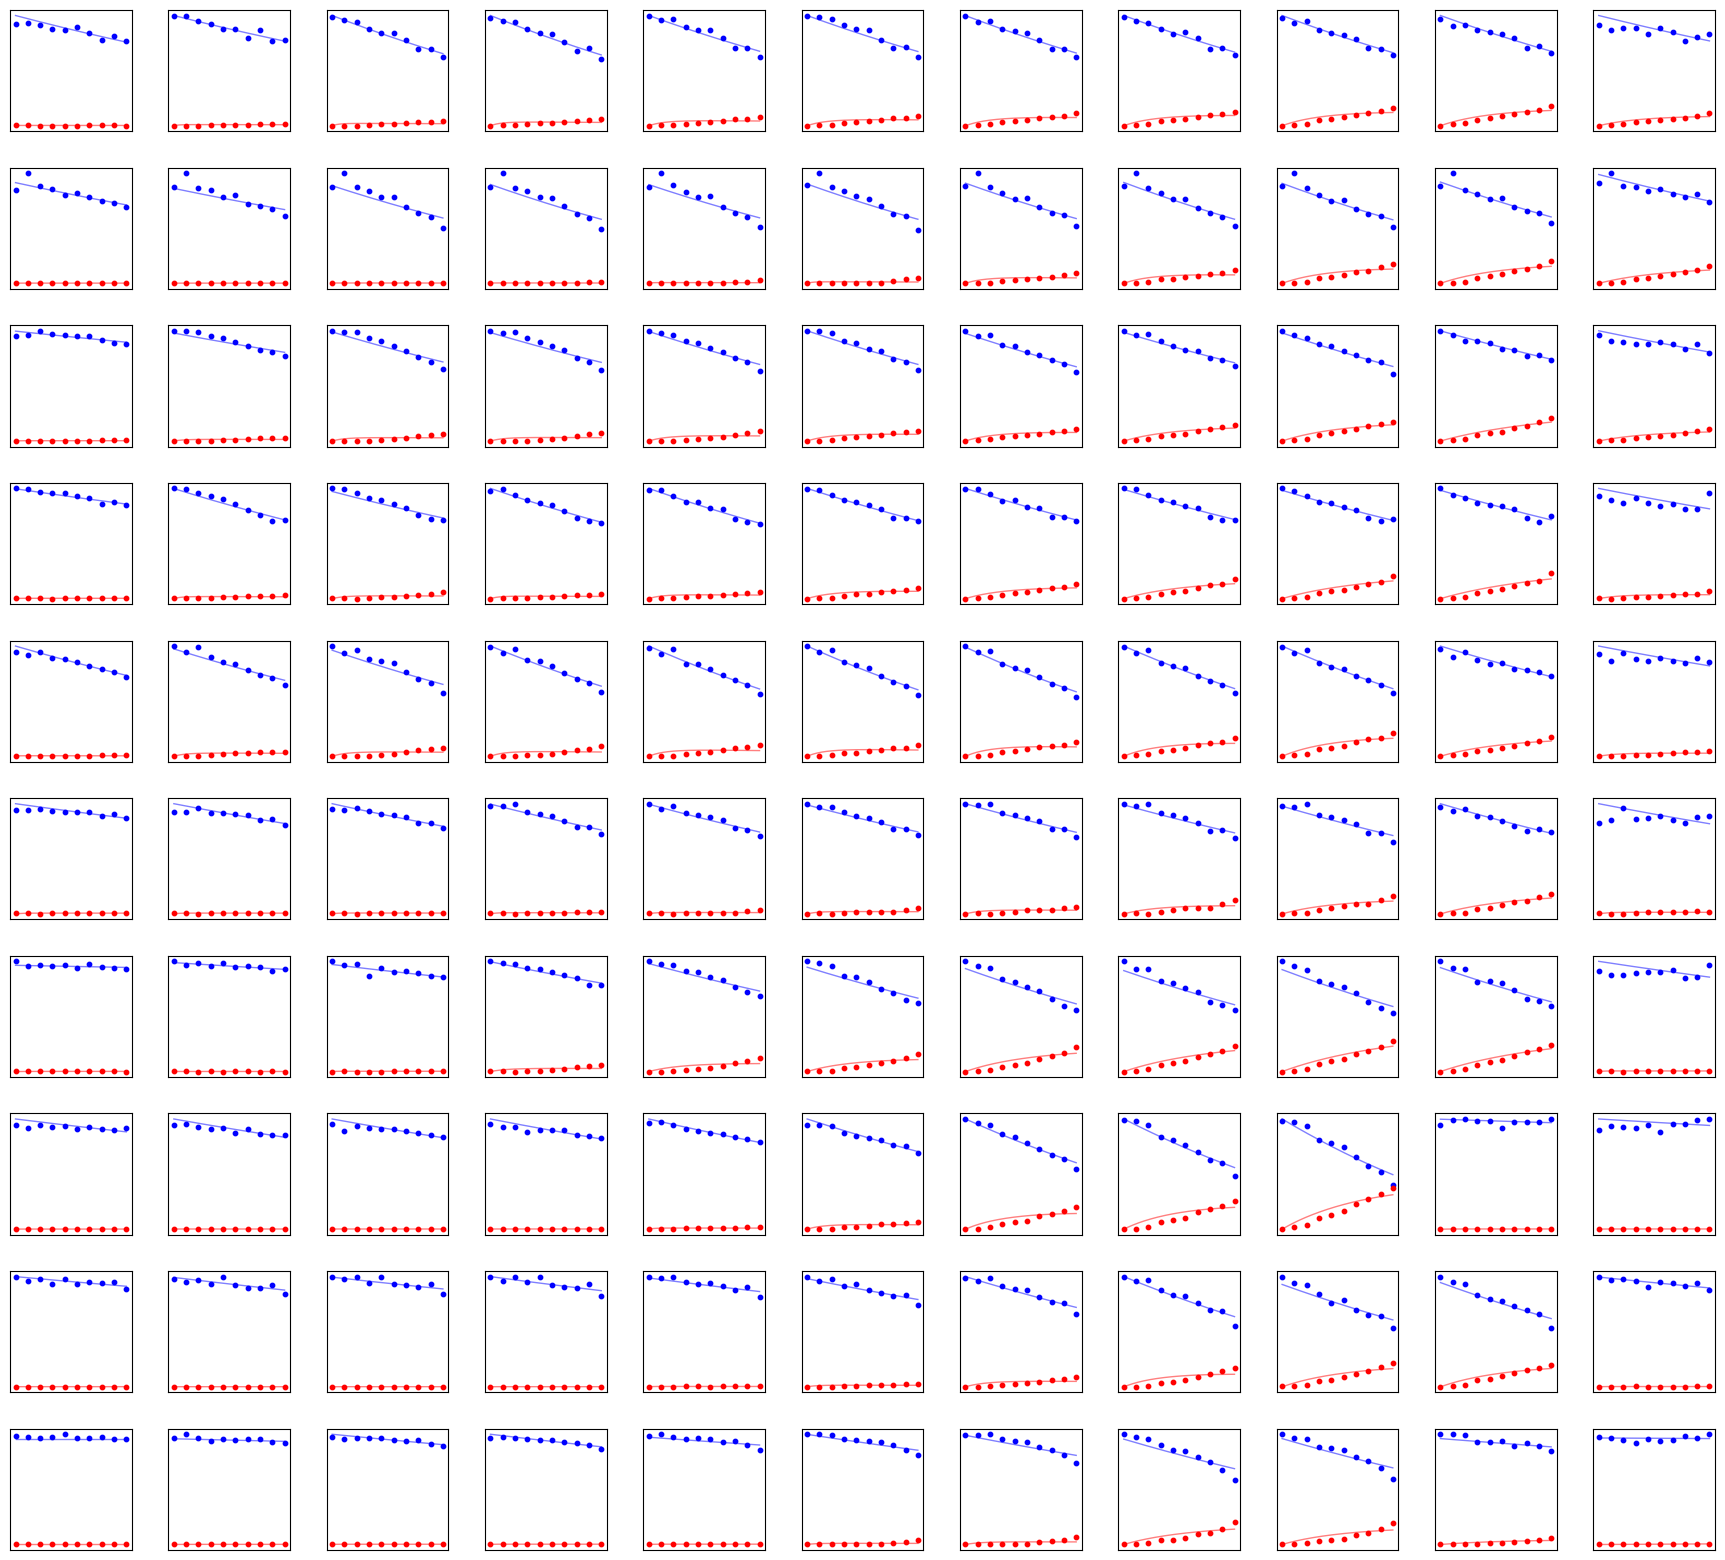

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mgsa.io import get_function, samples_from_soils


fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 3
K_A = K_I = K_C = 1
mu = 0.01 
dt = 0.05
T = 9
N = int(T/dt)

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[native])[pert]
        function = get_function(sample, drug = 'CHL')
        
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        print(A_data)
        y_data = np.concatenate([A_data, I_data])
        
        def model_drug(t, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate_drug(x_0, A_0, I_0, C_0, 
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0]
        bounds = ([0.0001, 0.0001,], [100, 100])
        
        popt, pcov = curve_fit(model_drug, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        x, A, I, C = simulate_drug(x_0, A_0, I_0, C_0, popt[0], popt[1],  K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

# Now with both drug and no drug

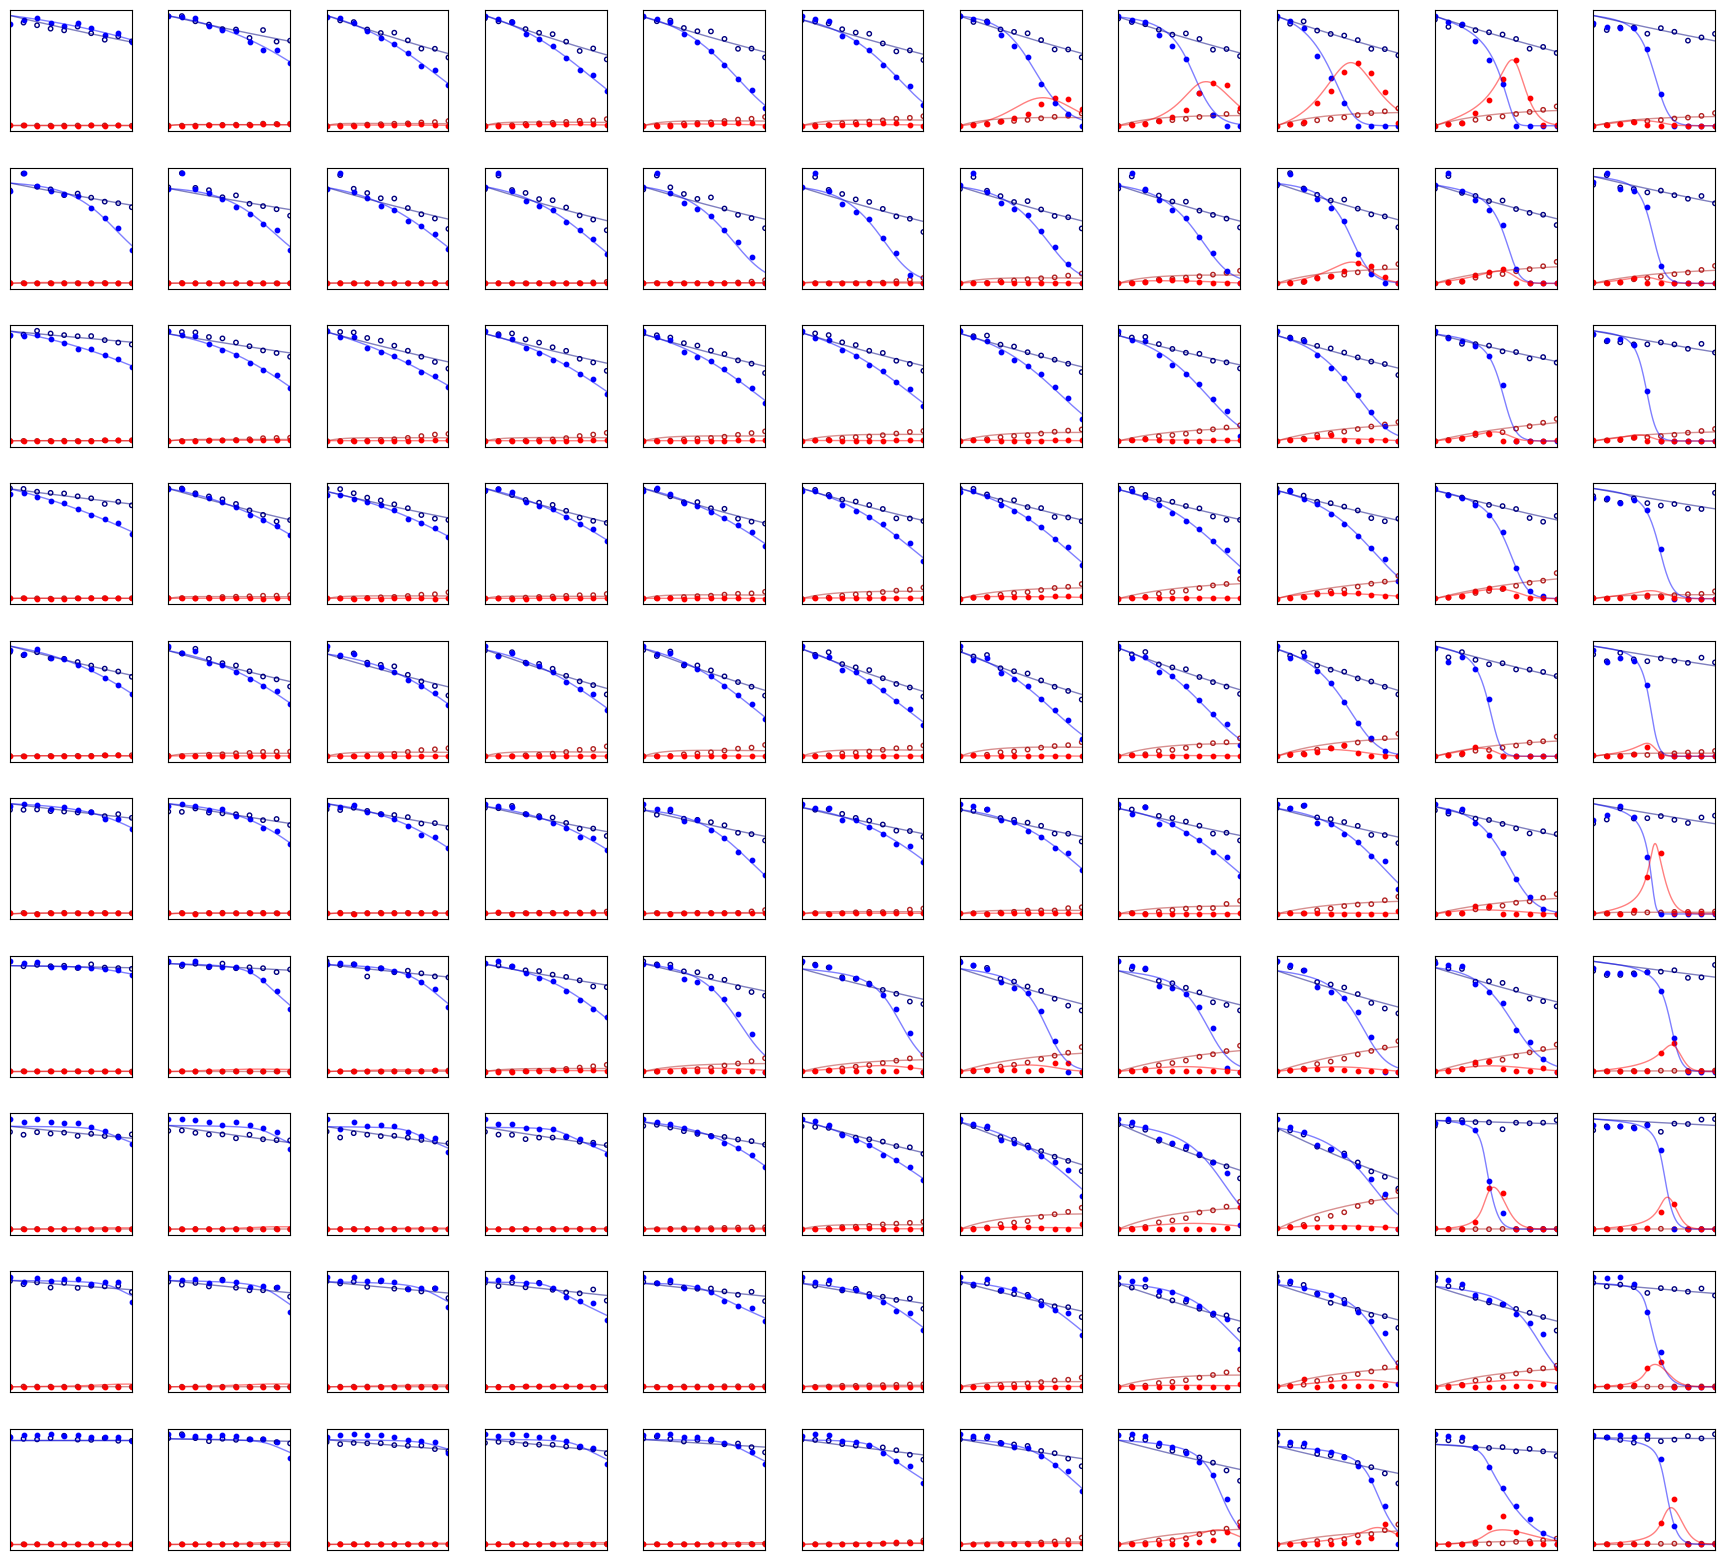

In [33]:

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 3
K_A = K_I = K_C = 1
mu = 0.01 
dt = 0.05
T = 9
N = int(T/dt)

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model_drug(t, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate_drug(x_0, A_0, I_0, C_0, 
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        
        initial_guess = [1.0, 1.0]
        bounds = ([0.0001, 0.0001,], [100, 100])
        
        popt, pcov = curve_fit(model_drug, t_data, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        x, A, I, C = simulate_drug(x_0, A_0, I_0, C_0, popt[0], popt[1],  K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        def model(t, gamma_A, gamma_I, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, 
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0, 0.1, 0.1]
        bounds = ([0.0001, 0.0001, 0.0001, 0.0001], [100, 100, 100, 100])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        x, A, I, C = simulate(x_0, A_0, I_0, C_0, popt[0], popt[1], 
                              popt[2], popt[3], K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()